<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/DRD2_similarity_activity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DRD2 Similarity–Activity Analysis
This notebook retrieves Dopamine D2 Receptor (CHEMBL217) data from ChEMBL, cleans it, computes molecular fingerprints, and analyzes the relationship between molecular similarity and bioactivity (pChEMBL values).

In [45]:
!pip install chembl_webresource_client rdkit pandas matplotlib seaborn scikit-learn xgboost

from chembl_webresource_client.new_client import new_client
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from rdkit import Chem
from rdkit.Chem import Draw, DataStructs
from rdkit.Chem import AllChem

# see the following webpage:

https://www.ebi.ac.uk/chembl/explore/target/CHEMBL217#NameAndClassification

protein and different known drugs shown

🔹 standard_value: This is the raw numeric value reported for the measurement, standardized to common units (e.g. nM). Example: if the original paper reported Ki = 50 μM, ChEMBL converts it to 50,000 nM and stores that in standard_value. It depends on the reported assay type, unit, and relation.

🔹 pChEMBL_value: This is a normalized logarithmic potency scale created by ChEMBL. This makes activity values from different assay types (Ki, Kd, IC50, etc.) comparable on a single scale. Higher pChEMBL = stronger binding (more potent).

🔹 choosing pChEMBL_value here.

In [46]:
target_id = "CHEMBL217"  # Dopamine D2 receptor

# 1. Download activities
activities = new_client.activity.filter(target_chembl_id=target_id).only(
    ["molecule_chembl_id", "canonical_smiles", "pchembl_value"]
)
df = pd.DataFrame(activities)
print("Raw activities:", len(df))

# 2. Fetch molecule type info for unique molecules
molecule = new_client.molecule
mol_info = []
for chembl_id in df["molecule_chembl_id"].unique():
    try:
        mol = molecule.get(chembl_id)
        mol_info.append({
            "molecule_chembl_id": chembl_id,
            "molecule_type": mol.get("molecule_type", None)
        })
    except:
        continue

mol_info = pd.DataFrame(mol_info)

# 3. Merge with activities
df = df.merge(mol_info, on="molecule_chembl_id", how="left")

# 4. Keep only small molecules
df = df[df["molecule_type"] == "Small molecule"].reset_index(drop=True)

df = df[["canonical_smiles", "pchembl_value"]]

print("After keeping only small molecules:", len(df))

Raw activities: 24629
After keeping only small molecules: 19725


In [48]:
# view a few rows of what we have downloaded:
df.head()

,canonical_smiles,pchembl_value
0,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,5.01
1,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,7.30
2,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,10.17
3,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,6.72
4,NC(=O)[C@H]1CS[C@@H]2CC[C@]3(CCCN3C(=O)[C@@H]3...,None


In [49]:
# 2) Cleaning the dataset

# Drop missing SMILES
df = df.dropna(subset=["canonical_smiles"]).reset_index(drop=True)

# Convert pchembl_value to numeric
df["pchembl_value"] = pd.to_numeric(df["pchembl_value"], errors="coerce")

# Drop missing activity values
df = df.dropna(subset=["pchembl_value"]).reset_index(drop=True)

# Remove duplicate molecules (keep best / highest pChEMBL value if multiple entries)
df = df.drop_duplicates(subset="canonical_smiles").reset_index(drop=True)

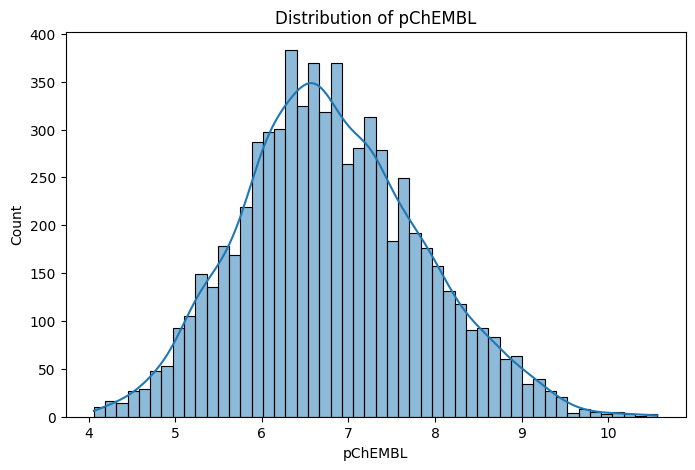

In [50]:
# 5) Histogram of pChEMBL
plt.figure(figsize=(8,5))
sns.histplot(df['pchembl_value'], bins=50, kde=True)
plt.xlabel("pChEMBL"); plt.title("Distribution of pChEMBL"); plt.show()

# convert molecules to numbers that computer can understand

In [51]:
# Use MorganGenerator if available to avoid deprecation; otherwise fallback
use_morgan_generator = False
try:
    from rdkit.Chem.rdMolDescriptors import MorganGenerator
    gen = MorganGenerator(radius=2)  # radius 2, common choice
    use_morgan_generator = True
    print("Using MorganGenerator for fingerprints.")
except Exception as e:
    print("MorganGenerator not available, using GetMorganFingerprintAsBitVect (fallback).")
    gen = None

def smiles_to_bitvect(smiles, nBits=512, radius=2):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        if use_morgan_generator:
            bv = gen.GetFingerprintAsBitVect(mol, nBits=nBits)
        else:
            bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
        return bv
    except Exception as e:
        return None


MorganGenerator not available, using GetMorganFingerprintAsBitVect (fallback).


In [52]:

# converting to numbers
df['mol'] = df['canonical_smiles'].apply(lambda s: Chem.MolFromSmiles(s))
df = df.dropna(subset=['mol']).reset_index(drop=True)
df['fp'] = df['canonical_smiles'].apply(lambda s: smiles_to_bitvect(s))
df = df.dropna(subset=['fp']).reset_index(drop=True)
df['pchembl_value'] = df['pchembl_value'].astype(float)
print("Unique molecules:", len(df))


Streaming output truncated to the last 5000 lines.
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:19:50] DEPRECATION WARNING: please use MorganGenerator
[09:1

Unique molecules: 6783


[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerator
[09:19:55] DEPRECATION WARNING: please use MorganGenerat

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6783 entries, 0 to 6782
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   canonical_smiles  6783 non-null   object 
 1   pchembl_value     6783 non-null   float64
 2   mol               6783 non-null   object 
 3   fp                6783 non-null   object 
dtypes: float64(1), object(3)
memory usage: 212.1+ KB


In [53]:
# see a few rows containing fingerprints (fp)
# limit to only 1000 molecules otherwise memory problem and slow
#df=df.head(1000)

In [55]:
# 3) Similarity sampling
N = len(df)
n_samples = (N*(N-1))//2   # use all possible pairs

from rdkit import DataStructs
import itertools

pairs = []
for i, j in itertools.combinations(range(N), 2):  # all unique pairs
    fp1, fp2 = df.at[i, 'fp'], df.at[j, 'fp']
    sim = DataStructs.TanimotoSimilarity(fp1, fp2)
    act_diff = abs(df.at[i, 'pchembl_value'] - df.at[j, 'pchembl_value'])
    pairs.append({
        'i': i,
        'j': j,
        'similarity': sim,
        'activity_difference': act_diff
    })

pairs_df = pd.DataFrame(pairs)
print("Pairs generated:", len(pairs_df))


Pairs generated: 23001153


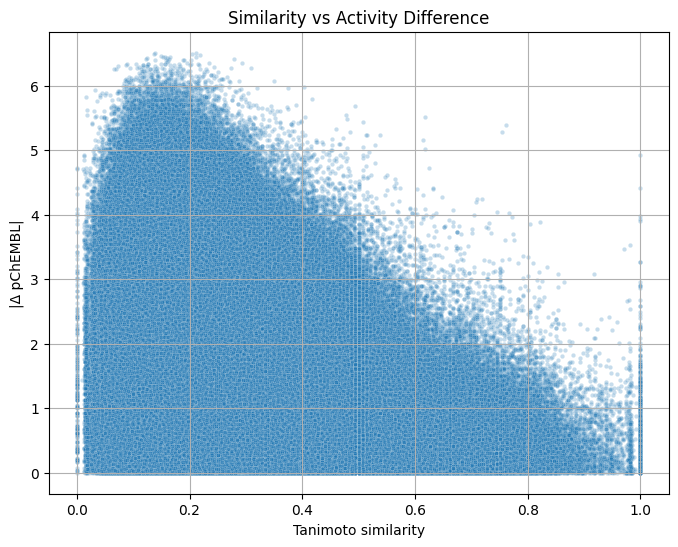

In [56]:
# 4) Scatter: similarity vs activity difference
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pairs_df,
    x='similarity', y='activity_difference', alpha=0.25, s=10)
plt.xlabel("Tanimoto similarity"); plt.ylabel("|Δ pChEMBL|")
plt.title("Similarity vs Activity Difference"); plt.grid(True); plt.show()



Empty DataFrame
Columns: [sim_bin_center, mean, std, count]
Index: []


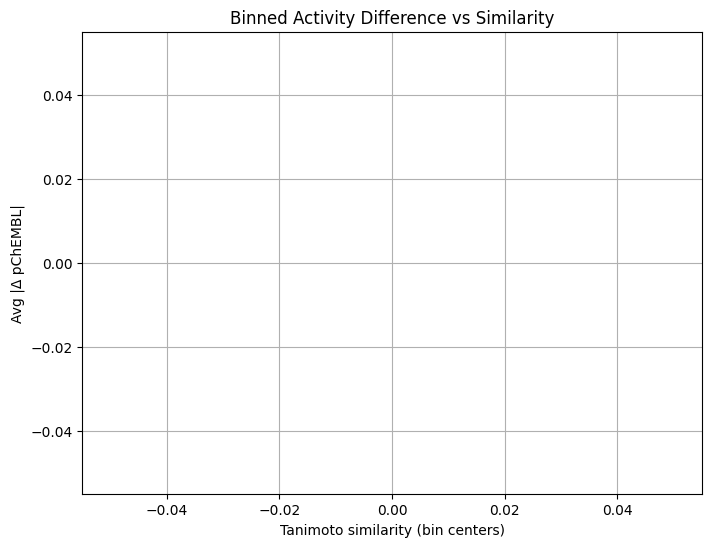

In [57]:
# 6) Binned stats
bin_edges = np.linspace(0.0, 1.0, 10)
pairs_df['sim_bin'] = pd.cut(pairs_df['similarity'], bins=bin_edges, include_lowest=True, right=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
intervals = pd.IntervalIndex.from_breaks(bin_edges, closed='right')
center_map = {intervals[i]: bin_centers[i] for i in range(len(bin_centers))}
pairs_df['sim_bin_center'] = pairs_df['sim_bin'].map(center_map)
binned_stats = pairs_df.groupby('sim_bin_center')['activity_difference'].agg(['mean','std','count']).reset_index()
print(binned_stats.head())

plt.figure(figsize=(8,6))
plt.errorbar(binned_stats['sim_bin_center'], binned_stats['mean'],
             yerr=binned_stats['std'], fmt='o-', capsize=5)
plt.xlabel("Tanimoto similarity (bin centers)"); plt.ylabel("Avg |Δ pChEMBL|")
plt.title("Binned Activity Difference vs Similarity"); plt.grid(True); plt.show()


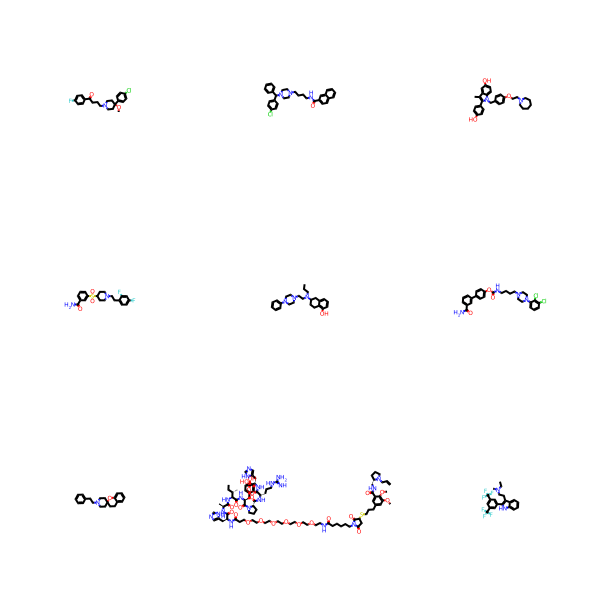

In [58]:
# 7) Example molecules grid
sample_mols = df.sample(min(9, len(df)))['mol'].tolist()
img = Draw.MolsToGridImage(sample_mols, molsPerRow=3, subImgSize=(200,200))
display(img)


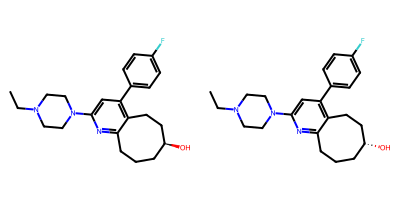

In [ ]:
# 8) Most similar and least similar molecules
pairs_df_sorted = pairs_df.sort_values('similarity', ascending=False).reset_index(drop=True)
for idx in range(len(pairs_df_sorted)):
    i,j = int(pairs_df_sorted.at[idx,'i']), int(pairs_df_sorted.at[idx,'j'])
    if df.at[i,'canonical_smiles'] != df.at[j,'canonical_smiles']:
        most_sim_row = pairs_df_sorted.loc[idx]; break
i,j = most_sim_row['i'], most_sim_row['j']
display(Draw.MolsToGridImage([df.at[i,'mol'], df.at[j,'mol']], molsPerRow=2))

pairs_df_sorted_low = pairs_df.sort_values('similarity', ascending=True).reset_index(drop=True)
for idx in range(len(pairs_df_sorted_low)):
    i,j = int(pairs_df_sorted_low.at[idx,'i']), int(pairs_df_sorted_low.at[idx,'j'])
    if df.at[i,'canonical_smiles'] != df.at[j,'canonical_smiles']:
        least_sim_row = pairs_df_sorted_low.loc[idx]; break
i,j = least_sim_row['i'], least_sim_row['j']
display(Draw.MolsToGridImage([df.at[i,'mol'], df.at[j,'mol']], molsPerRow=2))


In [ ]:

# 9) Save outputs
df_out = df[['canonical_smiles','pchembl_value']]
df_out.to_csv("DRD2_unique_molecules_pchembl.csv", index=False)
pairs_df.to_csv("DRD2_similarity_pairs_sampled.csv", index=False)
print("Saved output CSV files.")

# Goals for next meeting:

1. broadly understand this notebook (basic understanding of what each section is doing).
2. select 10 proteins of different classes that have many (thousands of) small molecule binders in CHEMBL or other databases. Make sure that these proteins are structurally different from each other.
3. Create a document (that will be later converted to paper) with sections - introduction, method, results, conclusion. And write a few lines about each section based on your understanding of the project and what you want to do.
4. Install pymol (free version) or some other software to visualize molecules (be able to load .pdb file and visualize it)
